# Cluster Analysis with K-means (Text Clustering)

<img style="float: l;" src="./images/k-means-clustering.png" width="500px">

## Environment Setup

#### First we will import some Python packages that we will use.

In [1]:
import nltk
import re
import math
import pandas as pd
import pickle as pkl
import numpy as np
from string import punctuation
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS
%matplotlib inline 
import matplotlib.pyplot as plt


## More Environment Setup

#### We may also need to pull in some nltk resources. These resources will help us clean the data.

In [2]:
nltk.download("stopwords")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jferraro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jferraro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Syntatic NLP Processing

#### We will define some Python functions that will perform some syntatic work on our corpus. 

In [4]:
# This function will remove unnecessay puncuation that can add to noise
def stripPunctuation(text):
    return ''.join(c for c in text if c not in punctuation)

# We will want to eventually tokenize a document into sentences and words
def tokenize(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out tokens not containing letters (e.g., numeric tokens, some punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

# We cache the stopword upfront for perfomance
cachedStopWords = stopwords.words("english")

# We will want to remove stopwords which are typiccially high frequency words that aid with  
# text fluency but do not provide much information gain.
def removeStopwords(text):
    no_stop = ' '.join([word for word in text.split() if word not in cachedStopWords])
    return no_stop

## Retrieving our Corpus

#### Let's pull in our corpus that we had serialized out to disk.  

In [5]:
file = open('differential-corpus.pkl','rb')
#file = open('pna-corpus.pkl','rb')
corpus = pkl.load(file)
file.close()
corpus.head()

,text,label
0,[**2996-12-2**] 10:25 AM\n CT CHEST W/O CONTRA...,PNA
1,[**3201-9-21**] 4:50 PM\n CT CHEST W/CONTRAST ...,PNA
2,[**3299-6-23**] 5:06 PM\n CT CHEST W/CONTRAST ...,PNA
3,[**3186-6-14**] 2:54 PM\n CT CHEST W/CONTRAST ...,PNA
4,[**2500-1-17**] 9:41 PM\n CT CHEST W/O CONTRAS...,PNA


##  Preparing our Corpus for Processing

#### First step is to clean up our corpus. We will strip pucntuation, remove stopwords, and tokenize our text. Actually removing stopwords and tokinization can be done by a downstream function as you will see. We do it here on the first document in our corpus just so you can get a good sense how the corpus gets transformed.

In [6]:
cleanedCorpus = []
ranks = []
labels = []
first = True
for index, row in corpus.iterrows():
    cleanedText = stripPunctuation(row['text'])
    if (first):
        print("**** ORIGINAL CLINICAL DOCUMENT ****")
        print()
        print("Index = " + str(index))
        print(row['text'])
        print("**** SOME PUNCTUATION REMOVED ****")
        print()        
        print(cleanedText)
        print("**** STOP WORDS REMOVED ****")
        print()
        textWithoutStopwords = removeStopwords(cleanedText)
        print(textWithoutStopwords)
        tokenizedText = tokenize(cleanedText)
        print()
        print("**** LOWER CASE AND TOKENIZE ****")
        print()
        print(tokenizedText)
        print()
        first = False
    cleanedCorpus.append(cleanedText)
    labels.append(row['label'] + str(index)) 
#    if row['label'] == 0:
#        labels.append('NEG-' + str(index))
#    else:
#        labels.append('POS-' + str(index))
    ranks.append(index)
        

**** ORIGINAL CLINICAL DOCUMENT ****

Index = 0
[**2996-12-2**] 10:25 AM
 CT CHEST W/O CONTRAST                                           Clip # [**Clip Number (Radiology) 38620**]
 Reason: please eval for loculated pleural effusion on the right and
 Field of view: 30
 ______________________________________________________________________________
 UNDERLYING MEDICAL CONDITION:
  73 year old woman with h/o RUL subtotal resection for lung CA (3/'[**95**]) as well
  as a LLL superior segment resection  for Tb and now presents w/ a RLL PNA and
  parapneumonic effusion concerning for empyema
 REASON FOR THIS EXAMINATION:
  please eval for loculated pleural effusion on the right and place a pigtail
  catheter (send specimen for Gm stain C+S, AFB smear, cytology, Fungal culture)
  please do ASAP as pt may require to go to the OR later this afternoon
 ______________________________________________________________________________
                                 FINAL REPORT
 INDICATION:  [** L

##  Quantifying our Clinical Corpus for Cluster Analysis

#### We need to somehow quantify the importance of the words found in a document relative to one another, as well as, relative to the entire corpus. Simply using frequency counts of words are a bias measurement. Longer documents naturally will have greater term frequencies than shorter documents. 

#### We can borrow from the field of informatin retrieval and use a measurement known as tf-idf, short for term frequency-inverse document frequency. This statistic is intended to reflect how important a word is in a document relative to the other words found in the document, as well as, relative to how often a word may be used across a corpus. 

#### TfidfVectorizer will not only produce our tf-idf word statistics but it will also first remove less important words known as stopwords and tokenize our corpus. The end result is a sparse matrix where each row represents a document in our corpus and each column is a distinct word found across all of the documents. 

#### 1) You should be able to understand why we want this information represented as a sparse matrix. Why do you think? 


In [7]:
# Note that max-df is set such that we keep words that can appear across 100% of the corpus and min-df is set
# such that we throw away words that are in less than 10% of our document corpus. We will also generate 
# unigrams and bigrams which is about right form clinical notes. Beyond bigrams we get very sparse....
tfidfVectorizer = TfidfVectorizer(max_df=1.0, max_features=200000,
                                  min_df=0.1, stop_words='english',
                                  use_idf=True, tokenizer=tokenize, ngram_range=(1,2))   

tfidfMatrix = tfidfVectorizer.fit_transform(cleanedCorpus)

print("**** STORED AS A SPARSE MATRIX ****")
print(tfidfMatrix.shape)
print()

**** STORED AS A SPARSE MATRIX ****
(1500, 303)



In [8]:
reduced = tfidfMatrix[0:1000, :]
reduced = reduced.todense();
print(reduced.shape)

(1000, 303)


In [11]:
tfidfMatrix.todense()

matrix([[0.02660909, 0.08316508, 0.13750634, ..., 0.        , 0.01147648,
         0.01149183],
        [0.03856756, 0.        , 0.        , ..., 0.        , 0.01663416,
         0.01665641],
        [0.        , 0.14256442, 0.11785902, ..., 0.        , 0.01967337,
         0.01969969],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.06632528,
         0.06641401],
        [0.14408469, 0.        , 0.        , ..., 0.        , 0.02071454,
         0.02074225],
        [0.        , 0.        , 0.        , ..., 0.        , 0.0494361 ,
         0.04950224]])

##  Generated Data to Keep

#### We want to hold onto the terms that were selected by our tf-idf vectorizer. 

#### We will also perform some high-dimensional geometry by calculating the cosine angel between multi-dimensional vectors that represent the text documents. Each element in the document vector represents a distint word that was used in the document. This word element is represented as a tf-idf numeric value. The cosine angle between two document vectors can be measured to determine how alike in topic two documents may be. We will calculate the pairwise similarity between all document pairs. We will need these distance measures for later when we try to visualize our clusters. 

$$\displaystyle  \vec{a} \cdot \vec{b} = \|\vec{a}\|\|\vec{b}\|\cos{\theta} \\ \\  \cos{\theta} = \frac{\vec{a} \cdot \vec{b}}{\|\vec{a}\|\|\vec{b}\|}$$

$$\theta = \arccos{\frac{\vec{a} \cdot \vec{b}}{\|\vec{a}\|\|\vec{b}\|}}$$

<img style="float: l;" src="./images/pathag.png" width="300px">



In [10]:
distinctTerms = tfidfVectorizer.get_feature_names()
print("**** SOME DISTINCT TERMS ***")
print(distinctTerms[-10:])
print(distinctTerms[:10])
print()
reddist = cosine_similarity(reduced)
reddist[reddist > 1.0] = 1.0
varccos = np.vectorize(math.acos)
radians = varccos(reddist)
vdegrees = np.vectorize(math.degrees)
deg = vdegrees(radians)
np.set_printoptions(precision=2, suppress=True)
print(deg)
dist = 1 - cosine_similarity(tfidfMatrix)


**** SOME DISTINCT TERMS ***
['wall', 'wet', 'wet read', 'windows', 'wo', 'wo contrast', 'woman', 'worsening', 'year', 'year old']
['abdomen', 'acute', 'adjacent', 'administration', 'admitting', 'admitting diagnosis', 'adrenal', 'air', 'amt', 'amt final']

[[ 0.   59.79 63.18 ... 83.09 74.96 85.88]
 [59.79  0.   66.06 ... 82.37 70.99 83.08]
 [63.18 66.06  0.   ... 74.58 65.65 84.04]
 ...
 [83.09 82.37 74.58 ...  0.   78.25 69.79]
 [74.96 70.99 65.65 ... 78.25  0.   77.87]
 [85.88 83.08 84.04 ... 69.79 77.87  0.  ]]


##  Time to Build Clusters

#### We will use K-means clustering to search for symantic patterns within our corpus.  K-means is a vector quantization method that attemps to partition $N$ observations (our clinical documents) into $K$ clusters. It assigns an observation to a cluster by trying to allign the observations with the cluster centroid. The cluster centroid represents the center of the cluster. K-means tries to minimize the within-cluster-variance which is a measure of compactness. So the idea is to generate as compact clusters as possible given a set of observations to assign.  

#### K-means is known as a hard-clustering method because each observations must be assigned to a single cluster. Other clustering methods such as expectation-maximization are known as soft-clustering methods because an observation can belong to multiple clusters with a certain probability. 

#### With K-means we need to determine the number of clusters we will produce aprioi. There is no magic here, the best approach is performing some trial and error. 


In [11]:
numClusters = 10
km = KMeans(n_clusters=numClusters)
km.fit(tfidfMatrix)
clusters = km.labels_.tolist()

## Some Basic Cluster Statistics

#### Let's look at the number of documents that were assigned to each cluster. We can also take a look at the group mean of the cluster althogh it does not provide a great deal of information.

In [12]:
clinicalDocuments = { 'labels': labels, 'rank': ranks, 'corpus': cleanedCorpus, 'cluster': clusters }
frame = pd.DataFrame(clinicalDocuments, index = [clusters] , columns = ['rank', 'labels', 'corpus', 'cluster'])
print("**** CLUSTER COUNTS ****")
print(frame['cluster'].value_counts())
print()
grouped = frame['rank'].groupby(frame['cluster'])
print("**** CLUSTER MEANS ****")
print(grouped.mean())
print()


**** CLUSTER COUNTS ****
0    234
1    229
3    180
7    151
5    143
6    137
9    129
2    126
4     95
8     76
Name: cluster, dtype: int64

**** CLUSTER MEANS ****
cluster
0    209.542735
1    193.349345
2    305.984127
3    284.738889
4    260.421053
5    234.916084
6    258.737226
7    276.238411
8    203.144737
9    311.643411
Name: rank, dtype: float64



## Better Insight into our Clusters

#### We will obviously want to understand what documents clustered together and the important terms that were found common among the documents in the cluster. Check out the cluster output.


In [13]:
print("**** TOP 10 TERMS PER CLUSTER ****")
orderedCentroids = km.cluster_centers_.argsort()[:, ::-1] # get indexes - sort smallest to largest then reverse order, largest to smallest
orderedCentroidScores = []
for i in range(numClusters):
    orderedCentroidScores.append(km.cluster_centers_[i, orderedCentroids[i,:]])  
for i in range(numClusters):
    print("Cluster# %d Words:" % i, end='')
    j = 0
    for indice in orderedCentroids[i, :10]:
        print(' %s: %.5f' % (distinctTerms[indice].split(' ')[0], orderedCentroidScores[i][j]), end=',')
        j += 1
    print()
    print()
    print("Cluster# %d Titles:" % i, end='')
    for label in frame.loc[i]['labels'].values.tolist():
        print(' %s,' % label, end='')
    print()
    print()


**** TOP 10 TERMS PER CLUSTER ****
Cluster# 0 Words: contrast: 0.24439, ct: 0.17782, optiray: 0.13022, right: 0.11146, pulmonary: 0.10323, lobe: 0.09797, amt: 0.09768, contrast: 0.09653, cta: 0.09622, optiray: 0.09590,

Cluster# 0 Titles: PNA1, PNA2, PNA5, PNA8, PNA10, PNA11, PNA15, PNA17, PNA18, PNA21, PNA27, PNA29, PNA32, PNA33, PNA34, PNA36, PNA41, PNA43, PNA44, PNA50, PNA52, PNA55, PNA56, PNA62, PNA66, PNA68, PNA69, PNA71, PNA72, PNA75, PNA76, PNA77, PNA79, PNA80, PNA82, PNA85, PNA86, PNA90, PNA91, PNA97, PNA102, PNA104, PNA109, PNA110, PNA111, PNA112, PNA116, PNA117, PNA118, PNA119, PNA120, PNA121, PNA124, PNA125, PNA126, PNA128, PNA138, PNA141, PNA143, PNA146, PNA149, PNA151, PNA152, PNA158, PNA159, PNA161, PNA164, PNA166, PNA169, PNA171, PNA176, PNA177, PNA182, PNA183, PNA184, PNA187, PNA188, PNA190, PNA193, PNA198, PNA199, PNA200, PNA203, PNA206, PNA214, PNA218, PNA224, PNA233, PNA238, PNA256, PNA264, PNA267, PNA269, PNA270, PNA271, PNA272, PNA275, PNA283, PNA285, PNA289, PNA29

## Cluster Visualization

#### We have a bit of a problem in that we can only conceptualize what high-dimensional space must look like. We are only able to visualize 3-dimensional space and most of us prefer 2-dimensional visualization. With text clustering we are dealing with 100's of dimensions, one for each vector term we used. Well the good news is that we have figured out how to perform reduction mappiing which projects high-dimensional space onto lower 2-dimensional space for visualizetion. We will use a process known as multidemensional scaling that attemps to preserve the distance between objects when reduced to low dimensional space. This may take a little time so be patient, eventually you will see the clusters in 2-dimensional space.    

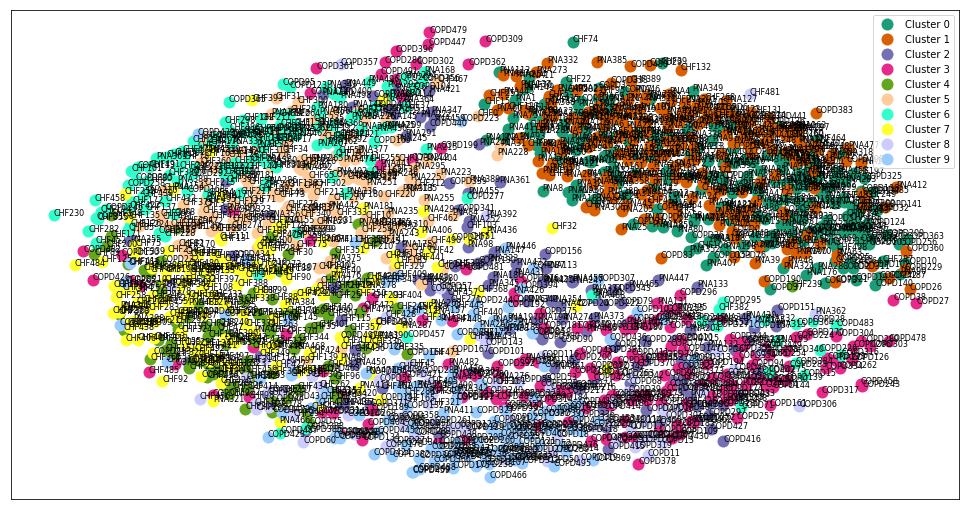

In [16]:
#plt.switch_backend('agg')
# Multidimensional scaling (MDS) is a means of visualizing the level of similarity of individual cases in a dataset. 
# MDS aims to place each object in n-dimensional space such that the between-object distances are preserved
# in the reduction mapping to two-dimensional space.
MDS()
# "precomputed" because we provide a distance matrix
# "random_state" so the plot is reproducible
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)
xs, ys = pos[:, 0], pos[:, 1]
#set up colors for each clusters
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e', 
                  5: '#ffcc99', 6: '#33ffcc', 7: '#FFFF33', 8: '#ccccff', 9: '#99ccff'}
#set up cluster names for each color
cluster_names = {0: 'Cluster 0', 1: 'Cluster 1', 2: 'Cluster 2', 3: 'Cluster 3', 4: 'Cluster 4', 
                 5: 'Cluster 5', 6: 'Cluster 6', 7: 'Cluster 7', 8: 'Cluster 8', 9: 'Cluster 9'} 
#result of the MDS along with the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=labels)) 
#group by cluster
groups = df.groupby('label')
# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05)
#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=cluster_names[name], color=cluster_colors[name], mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelleft=False)   
ax.legend(numpoints=1)  #show legend with only 1 point
#add label in x,y position with the label as the document name
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  
plt.show() #show the plot